In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('bengaluru_house_prices.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df.shape

(13320, 9)

In [4]:
# I will examine the area_type feature first
df.groupby('area_type')['area_type'].agg('count')

,area_type
area_type,
Built-up Area,2418
Carpet Area,87
Plot Area,2025
Super built-up Area,8790


In [5]:
# To keep model simple, im going to drop the unncessary features
df2 = df.drop(['area_type', 'society', 'balcony', 'availability'], axis = 'columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [6]:
# Now begins the data cleaning process,
# Lets start with handling the null values
df2.isnull().sum()

,0
location,1
size,16
total_sqft,0
bath,73
price,0


In [7]:
# Since the bath and size are very less values compared to 13320 rowse, i will just drop safely
df3 = df2.dropna()

In [8]:
df3.isnull().sum()

,0
location,0
size,0
total_sqft,0
bath,0
price,0


In [9]:
# Now im gonna explore the size feature, i can see that some values are not proerpyl formatted and strcutured, like 2 BHK, 4 Bedroom, etc. I will create a new feature[BHK] whcih will properly display the values
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [10]:
df3['BHK'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))

/tmp/ipython-input-3303903377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['BHK'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


In [11]:
df3[df3.BHK > 20] # This dosent make sense as there are 43 bedrooms in a 2400 sq.ft area

,location,size,total_sqft,bath,price,BHK
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [12]:
# Since we're mentioning about total_sqft, I want to check the unique values to see if there is anything strange
df3['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [13]:
# Ahaa, i saw that there is 113 - 1384 range value, i want them all as float values, i will crearte a function that converts all these values to float
def is_float(x):
  try:
    float(x)
  except:
      return False

  return True

In [14]:
df3[~df3['total_sqft'].apply(is_float)] # I want to see the values which wll return false, so i will negate

,location,size,total_sqft,bath,price,BHK
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
...,...,...,...,...,...,...
12975,Whitefield,2 BHK,850 - 1060,2.0,38.190,2
12990,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000,3
13059,Harlur,2 BHK,1200 - 1470,2.0,72.760,2
13265,Hoodi,2 BHK,1133 - 1384,2.0,59.135,2


In [15]:
#Ahaa, i see all the range values not being in float, so now I will define a function

In [16]:
def convert_sqft_to_float(x):
  tokens = x.split('-')
  if len(tokens) == 2:
    return (float(tokens[0]) + float(tokens[1]))/2
  try:
    return float(x)
  except:
    return None

In [17]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_float)

In [18]:
df4.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [19]:
df4['total_sqft'].unique() # Now all are float!

array([1056. , 2600. , 1440. , ..., 1258.5,  774. , 4689. ])

In [20]:
# Now what shall we do is, we will create a new feature called price_per_sqft, since its very imp in real estate prediction

In [21]:
df5 = df4.copy()

In [22]:
#Feature engineering

In [23]:
df5['price_per_sqft'] = df5['price'] * 100000 /df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [24]:
#Now we are going to explore location feautre. If we have too many locations it will creat a problem

In [25]:
len(df5.location.unique())

1304

In [26]:
# Soo many locations, 1300, its too much and a problem when doing one hot encoding

In [27]:
# Its called a Dimensionality Curse

In [28]:
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats.head(10)

,location
location,
Whitefield,534
Sarjapur Road,392
Electronic City,302
Kanakpura Road,266
Thanisandra,233
Yelahanka,210
Uttarahalli,186
Hebbal,176
Marathahalli,175


In [29]:
# I can wee Whitefield has many locations and some locatiosn have 1 datapoint.
# For data cleaning, lets say the location with less than 10 datapoints, are in the a "other" cateogry

In [30]:
len(location_stats[location_stats <= 10])

1063

In [31]:
location_stats_less_than_10 = location_stats[location_stats <= 10]
location_stats_less_than_10

,location
location,
Nagadevanahalli,10
Naganathapura,10
BTM 1st Stage,10
Nagappa Reddy Layout,10
Basapura,10
...,...
bsk 6th stage 2ad block near sri conversation hall,1
"beml layout, basaveshwara nagar",1
basaveshwarnagar,1


In [32]:
# I can put the above locations in a general cateogryb called other to do a cleanen data.
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

In [33]:
len(df5.location.unique())

242

In [34]:
# So now , when i apply one hot encoding in the future to locations, i only have 242 locations that will be good

In [35]:
#Now we will deal with outliers

In [36]:
df5.head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [37]:
# What is a typical sqft per bedroom?? Like 300, or 350

In [38]:

# Lets check now

In [39]:
df5[df5['total_sqft'] / df5['BHK'] < 300].head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,other,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [40]:
# Clearly, ther are data errors in the above data columns

In [41]:
df5.shape

(13246, 7)

In [42]:
df6 = df5[~(df5['total_sqft'] / df5['BHK'] < 300)] #Remove the ones which are causing error
df6.shape

(12502, 7)

In [43]:
df6.price_per_sqft.describe()

,price_per_sqft
count,12456.000000
mean,6308.502826
std,4168.127339
min,267.829813
25%,4210.526316
50%,5294.117647
75%,6916.666667
max,176470.588235


In [44]:
# Here min. price per sqft is 267, there is a lot of values for tyhe max, so we will remove that

In [45]:
def remove_pps_outliers(df):
  df_out = pd.DataFrame() #output df
  for key, subdf in df.groupby('location'): #group by location
    m = np.mean(subdf.price_per_sqft)
    std = np.std(subdf.price_per_sqft)
    reduced_df = subdf[(subdf.price_per_sqft > (m - std)) & (subdf.price_per_sqft <= (m + std))] #filter by > 1 and <= 1
    df_out = pd.concat([df_out, reduced_df], ignore_index = True)
  return df_out

df7 = remove_pps_outliers(df6)
df7.shape

(10244, 7)

In [46]:
# We have close to 2 thousand outliers!

In [47]:
# Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

In [48]:
df7.head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Devarachikkanahalli,3 BHK,1250.0,2.0,44.0,3,3520.000000
1,Devarachikkanahalli,2 BHK,1250.0,2.0,40.0,2,3200.000000
2,Devarachikkanahalli,2 Bedroom,1200.0,2.0,83.0,2,6916.666667
3,Devarachikkanahalli,2 BHK,1170.0,2.0,40.0,2,3418.803419
4,Devarachikkanahalli,3 BHK,1425.0,2.0,65.0,3,4561.403509


In [49]:
# Lets think like a real data scientist and real estate agent

In [50]:
def plot_scatter_chart(df, location):
  bhk2 = df[(df.location == location) & (df.BHK == 2)]
  bhk3 = df[(df.location == location) & (df.BHK == 3)]
  plt.figure(figsize = (10,6))
  plt.scatter(bhk2.total_sqft, bhk2.price, color = 'blue', label = '2 BHK')
  plt.scatter(bhk3.total_sqft, bhk3.price, color = 'green', label = '3 BHK', marker = '+')
  plt.xlabel('Total_sqft')
  plt.ylabel('Price')
  plt.title(location)
  plt.legend()
  plt.show()

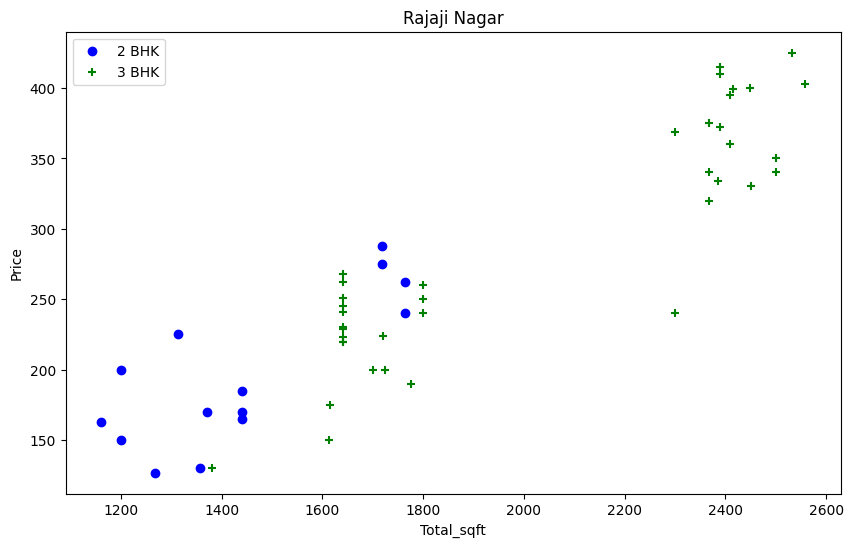

In [51]:
plot_scatter_chart(df7, 'Rajaji Nagar')

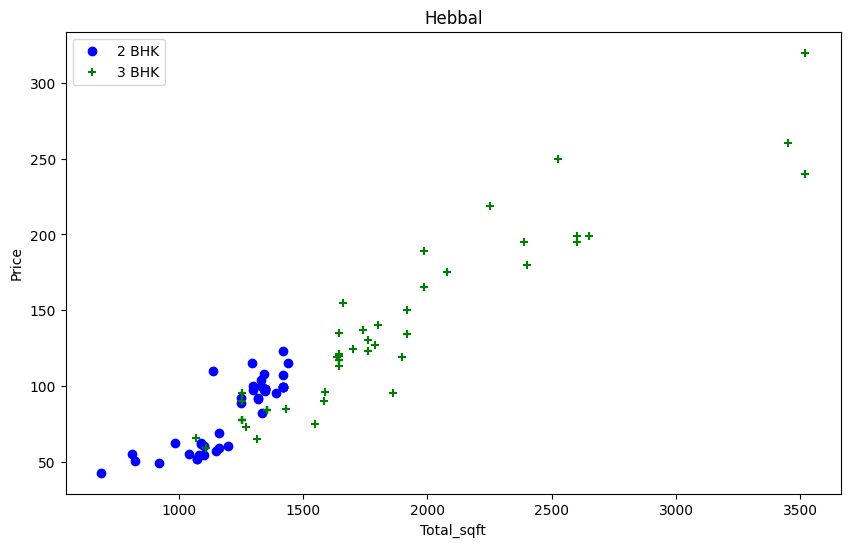

In [52]:
plot_scatter_chart(df7, 'Hebbal')

In [53]:
# Now i will createa function that will clacluatle all the statistics of 1BHK and 2BHK

In [54]:
def remove_bhk_outliers(df):
  exclude_indices =  np.array([])
  for location, location_df in df.groupby('location'):
    bhk_stats = {}
    for bhk, bhk_df in location_df.groupby('BHK'):
      bhk_stats[bhk] = {
          'mean' : np.mean(bhk_df.price_per_sqft),
          'std' : np.std(bhk_df.price_per_sqft),
          'count' : bhk_df.shape[0]
      }
    for bhk, bhk_df in location_df.groupby('BHK'):
      stats = bhk_stats.get(bhk - 1)
      if stats and stats['count'] > 5:
        exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
  return df.drop(exclude_indices, axis = 'index')

In [55]:
df8 = remove_bhk_outliers(df7)
df8.shape

(7342, 7)

In [56]:
# Removed mmore than 2 thousand outliers again

In [57]:
def plot_scatter_chart(df, location):
  bhk2 = df[(df.location == location) & (df.BHK == 2)]
  bhk3 = df[(df.location == location) & (df.BHK == 3)]
  plt.figure(figsize = (10,6))
  plt.scatter(bhk2.total_sqft, bhk2.price, color = 'blue', label = '2 BHK')
  plt.scatter(bhk3.total_sqft, bhk3.price, color = 'green', label = '3 BHK', marker = '+')
  plt.xlabel('Total_sqft')
  plt.ylabel('Price')
  plt.title(location)
  plt.legend()
  plt.show()

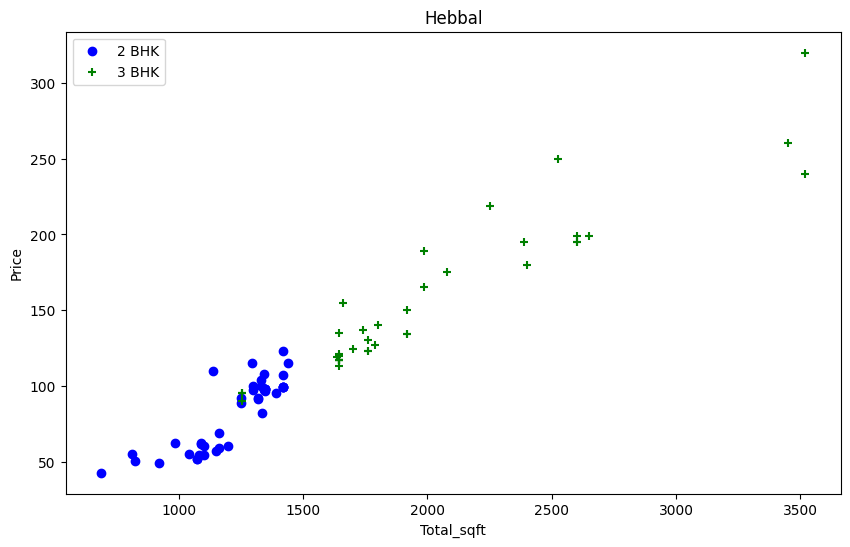

In [58]:
plot_scatter_chart(df8, 'Hebbal')

In [59]:
# Iwant to see how many apartments i have per sqft feet area

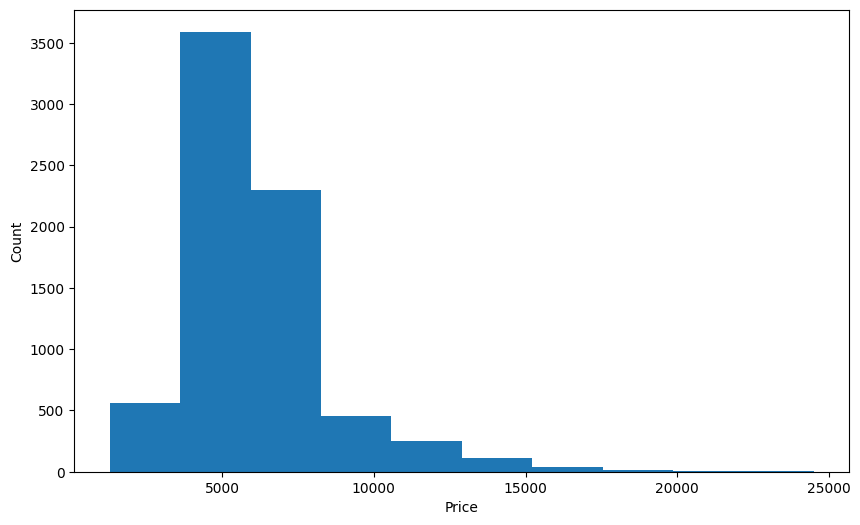

In [60]:
plt.figure(figsize = (10,6))
plt.hist(df8.price_per_sqft)
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

In [61]:
df8.head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
1,Devarachikkanahalli,2 BHK,1250.0,2.0,40.0,2,3200.000000
2,Devarachikkanahalli,2 Bedroom,1200.0,2.0,83.0,2,6916.666667
3,Devarachikkanahalli,2 BHK,1170.0,2.0,40.0,2,3418.803419
4,Devarachikkanahalli,3 BHK,1425.0,2.0,65.0,3,4561.403509
5,Devarachikkanahalli,2 BHK,947.0,2.0,43.0,2,4540.654699


In [62]:
# Now let me explore the bathroom values

In [63]:
df8.bath.unique()

array([ 2.,  3.,  4.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [64]:
# Outliers spotted! as more than 10 bathrooms

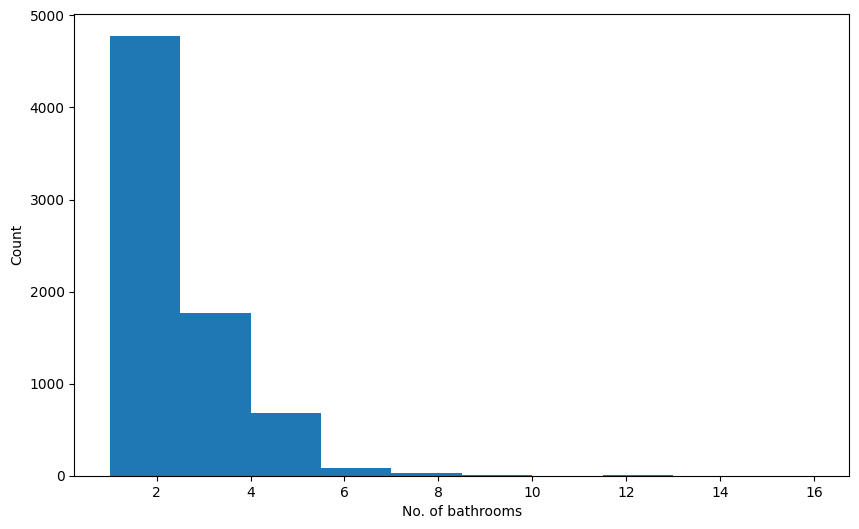

In [65]:
plt.figure(figsize = (10,6))
plt.hist(df8.bath)
plt.xlabel('No. of bathrooms')
plt.ylabel('Count')
plt.show()

In [66]:
df8[df8.bath > df8.BHK + 2]

,location,size,total_sqft,bath,price,BHK,price_per_sqft
1637,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5232,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6702,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8405,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [67]:
df9 = df8[df8.bath < df8.BHK + 2] # Cleaned the outliers

In [68]:
df9.shape

(7264, 7)

In [69]:
# For training, i can drop size feature and pricee_per_sqft feature only needthat for outlier detection

In [70]:
df10 = df9.drop(['size', 'price_per_sqft'], axis = 'columns')

In [71]:
df10.head()

,location,total_sqft,bath,price,BHK
1,Devarachikkanahalli,1250.0,2.0,40.0,2
2,Devarachikkanahalli,1200.0,2.0,83.0,2
3,Devarachikkanahalli,1170.0,2.0,40.0,2
4,Devarachikkanahalli,1425.0,2.0,65.0,3
5,Devarachikkanahalli,947.0,2.0,43.0,2


In [72]:
# Lets use get_dummies for OneHotEncoding

In [73]:
dummies = pd.get_dummies(df10.location, dtype = int)

In [74]:
df11 = pd.concat([df10, dummies.drop('other', axis = 'columns')], axis = 'columns') # I am appending the df10 and dummies dataframe. Also dropping one last columns other for avoiding the dummies error

In [75]:
df11.head()

,location,total_sqft,bath,price,BHK,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,Devarachikkanahalli,1250.0,2.0,40.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Devarachikkanahalli,1200.0,2.0,83.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Devarachikkanahalli,1170.0,2.0,40.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Devarachikkanahalli,1425.0,2.0,65.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Devarachikkanahalli,947.0,2.0,43.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:

df12 = df11.drop('location', axis = 'columns')
df12.head()

,total_sqft,bath,price,BHK,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,40.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,83.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1170.0,2.0,40.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1425.0,2.0,65.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,947.0,2.0,43.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
X = df12.drop('price', axis = 'columns')
y = df12['price']

In [78]:
X.head()

,total_sqft,bath,BHK,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1170.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1425.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,947.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
y.head()

,price
1,40.0
2,83.0
3,40.0
4,65.0
5,43.0


In [80]:
from sklearn.model_selection import train_test_split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [82]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [83]:
lr.fit(X_train, y_train)

LinearRegression()

In [84]:
lr.score(X_test, y_test)

0.8508199138740118

In [85]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)

cross_val_score(LinearRegression(), X, y, cv = cv)

array([0.82622151, 0.81408431, 0.87757267, 0.84822717, 0.86091226])

In [86]:
# As a data scientist, i want to try which model works best like other regression models, like decision tree, lasso

In [87]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

In [88]:
def find_best_model(X,y):
  algos = {
      'linear_regression' : {
          'model': LinearRegression(),
          'params': {
              # 'normalize': [True, False] # Removed normalize parameter
          }
      },
      'lasso' : {
          'model': Lasso(),
          'params':{
              'alpha': [1,2],
              'selection': ['random', 'cyclic']
          }
      },
      'decision_tree' : {
          'model': DecisionTreeRegressor(),
          'params':{
              'criterion': ['mse', 'friedman_mse'],
              'splitter': ['best', 'random']
          }
      }
  }

  scores= []
  cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
  for algo_name, config in algos.items():
    gs = GridSearchCV(config['model'], config['params'], cv = cv, return_train_score = False)
    gs.fit(X,y)
    scores.append({
        'model': algo_name,
        'best_score': gs.best_score_,
        'best_params': gs.best_params_
    })

  return pd.DataFrame(scores, columns =['model', 'best_score', 'best_params'])



find_best_model(X,y)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

,model,best_score,best_params
0,linear_regression,0.845404,{}
1,lasso,0.709714,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.718668,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [89]:
# Clearly my linear regression is winner here

In [90]:
X.columns

Index(['total_sqft', 'bath', 'BHK', ' Devarachikkanahalli',
       '1st Block Jayanagar', '1st Phase JP Nagar',
       '2nd Phase Judicial Layout', '2nd Stage Nagarbhavi',
       '5th Block Hbr Layout', '5th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)

In [91]:
def price_prediction(location, sqft, bath, bhk):
  loc_index = np.where(X.columns == location)[0][0]
  x = np.zeros(len(X.columns))
  x[0] = sqft
  x[1] = bath
  x[2] = bhk

  if loc_index >= 0:
    x[loc_index] = 1

  return lr.predict([x])[0]

In [92]:
#Price prediction for 1st Phase JP Nagar, 1000 sqft, 2 bedroom, 2bhk
price_prediction('1st Phase JP Nagar', 1000, 2, 2)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(88.68063584406399)

In [93]:
price_prediction('1st Phase JP Nagar', 1000, 3, 3)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(91.10829082669144)

In [94]:
# Lets export the model to a pickle file

In [95]:
import pickle
with open('banglore_home_prices_model.pickle', 'wb') as f:
  pickle.dump(lr, f)

In [96]:
# Importing into a json for easy predictions and how to structure inputs

In [97]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json", "w") as f:
  f.write(json.dumps(columns))